In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import yfinance as yf

# Modelado y Forecasting
from sklearn.ensemble import RandomForestRegressor ## 
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom

from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

import warnings
warnings.filterwarnings('ignore')

In [2]:
# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

 

In [3]:
today = datetime.today().strftime("%Y-%m-%d")
inicio= "2017-01-01"
ticker="GOOG"
df = yf.download(ticker, start=inicio, end=today)

[*********************100%***********************]  1 of 1 completed


# **Análisis Gráfico**

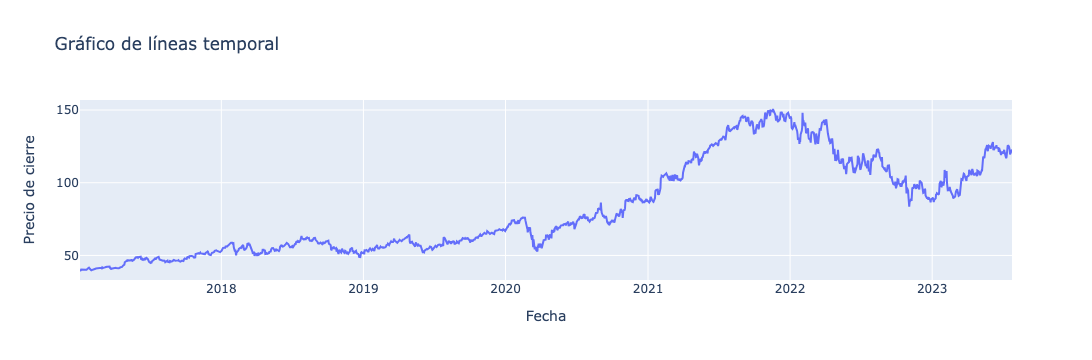

In [4]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index,y=df["Close"],mode="lines",name="Precio de Cierre"))
fig.update_layout(title='Gráfico de líneas temporal',
                  xaxis_title='Fecha',
                  yaxis_title='Precio de cierre')
fig.show()

In [5]:
VariacionDiaria=df["Close"]/df["Close"].shift(1)-1
df["Retornos"]=VariacionDiaria

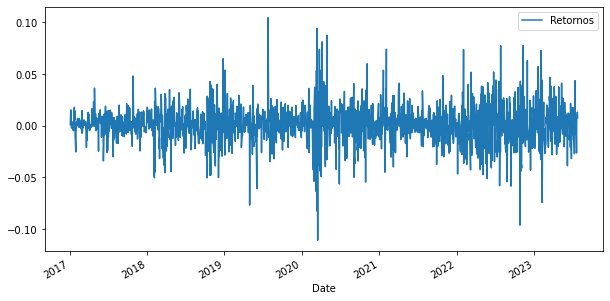

In [6]:
df[["Retornos"]].plot(figsize=(10,5))
plt.show()

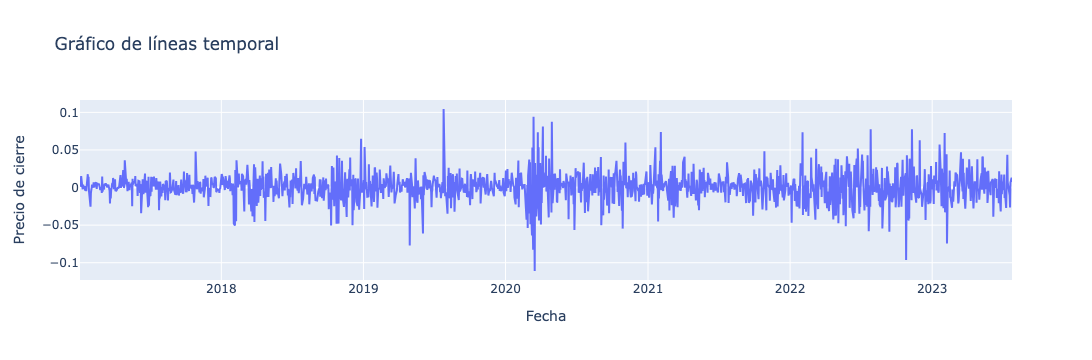

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index,y=df["Retornos"],mode="lines",name="Precio de Cierre"))
fig.update_layout(title='Gráfico de líneas temporal',
                  xaxis_title='Fecha',
                  yaxis_title='Precio de cierre')
fig.show()

## **Revisamos Estacionalidad de forma Gráfica**

In [8]:
y=df["Close"].resample("M").mean()

In [12]:
df=pd.DataFrame({"Fecha":y.index,"Close":y})

In [13]:
#df["Fecha"]=df.index

In [14]:
## Algunas Variables Temporales

In [15]:
dw_mapping={
    0: 'Lunes', 
    1: 'Martes', 
    2: 'Miércoles', 
    3: 'Jueves', 
    4: 'Viernes',
    5: 'Sábado', 
    6: 'Domingo'}
df["DiaSemana"]=df.Fecha.dt.weekday.map(dw_mapping)

In [16]:
dw_mapping={
    "01": 'Enero', 
    "02": 'Febrero', 
    "03": 'Marzo', 
    "04": 'Abril', 
    "05": 'Mayo',
    "06": 'Junio', 
    "07": 'Julio',
    "08": "Agosto",
    "09": "Septiembre",
    "10": "Octubre",
    "11":"Noviembre",
    "12": "Noviembre"}
df["Mes"]=df.Fecha.dt.strftime('%m').map(dw_mapping)
     

In [17]:
df1=df[["Close"]]

In [18]:
df1.rename(columns={"Close":"y"},inplace=True)

# **Skforecast: forecasting series temporales con Python y Scikit-learn**

Una serie temporal (time series) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. El proceso de forecasting consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas


<img src="https://www.cienciadedatos.net/images/forecasting_multi-step.gif
" width=800 align="right">


In [19]:
df1

y
Date                  
2017-01-31   40.395238
2017-02-28   40.845829
2017-03-31   41.705565
2017-04-30   42.202843
2017-05-31   46.964205
...                ...
2023-03-31   98.558696
2023-04-30  106.348422
2023-05-31  116.745682
2023-06-30  123.228096
2023-07-31  121.588749

[79 rows x 1 columns]

## **Separamos en Train y Test**

In [20]:
steps=6
datos_train=df1[:-steps]
datos_test=df1[-steps:]

In [21]:
datos_train.shape

(73, 1)

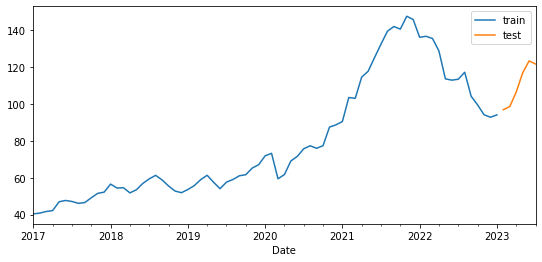

In [22]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

## **ForecasterAutoreg**

Se crea y entrena un modelo ForecasterAutoreg a partir de un regresor RandomForestRegressor y una ventana temporal de 6 lags. Esto último significa que, el modelo, utiliza como predictores los 6 meses anteriores.

In [23]:
model_rf= ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123),
                           lags=30)

In [24]:
model_rf.fit(y=datos_train["y"])

In [25]:
model_rf

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2017-01-31 00:00:00'), Timestamp('2023-01-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: M 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-07-26 18:01:59 
Last fit date: 2023-07-26 18:01:59 
Skforecast version: 0.4.3 

## **Predicciones**

In [26]:
Predicciones_rf=model_rf.predict(steps=steps)
Predicciones_rf

2023-02-28    94.337539
2023-03-31    94.012913
2023-04-30    94.401140
2023-05-31    94.342026
2023-06-30    94.342026
2023-07-31    94.678027
Freq: M, Name: pred, dtype: float64

In [27]:
datos_test["Predicciones Rf"]= Predicciones_rf.values

In [28]:
datos_test

y  Predicciones Rf
Date                                   
2023-02-28   96.808948        94.337539
2023-03-31   98.558696        94.012913
2023-04-30  106.348422        94.401140
2023-05-31  116.745682        94.342026
2023-06-30  123.228096        94.342026
2023-07-31  121.588749        94.678027

**Evaluamos el Error**

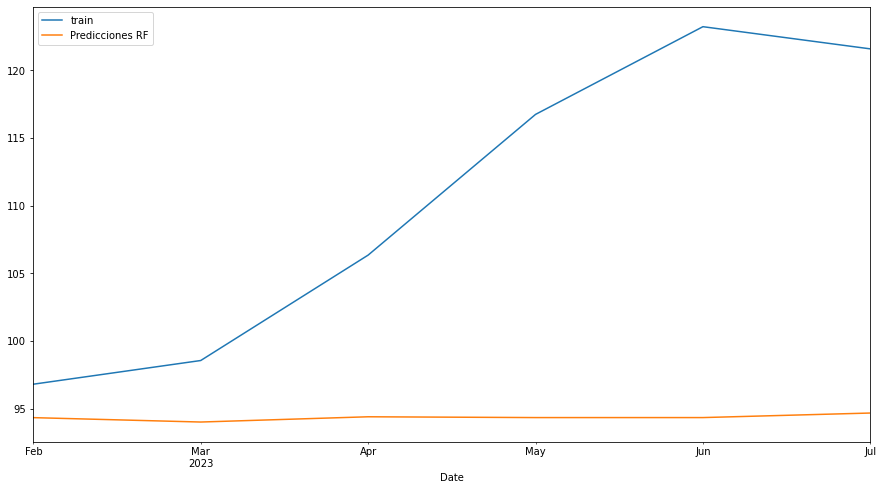

In [29]:
fig, ax = plt.subplots(figsize=(15, 8))
datos_test['y'].plot(ax=ax, label='train')
datos_test['Predicciones Rf'].plot(ax=ax, label='Predicciones RF')
ax.legend();

## **Error de las predicciones en el conjunto de test**

**Mape**: El término "MAPE" es una sigla que representa el "Error porcentual absoluto medio" en inglés, "Mean Absolute Percentage Error". Es una métrica utilizada en estadísticas y análisis de datos para evaluar la precisión de un modelo o pronóstico en comparación con los valores reales.

El MAPE se calcula tomando la diferencia absoluta entre los valores predichos y los valores reales, dividiendo esa diferencia por el valor real y luego multiplicándola por 100 para obtener un porcentaje. Luego, se promedian estos porcentajes para obtener el MAPE.


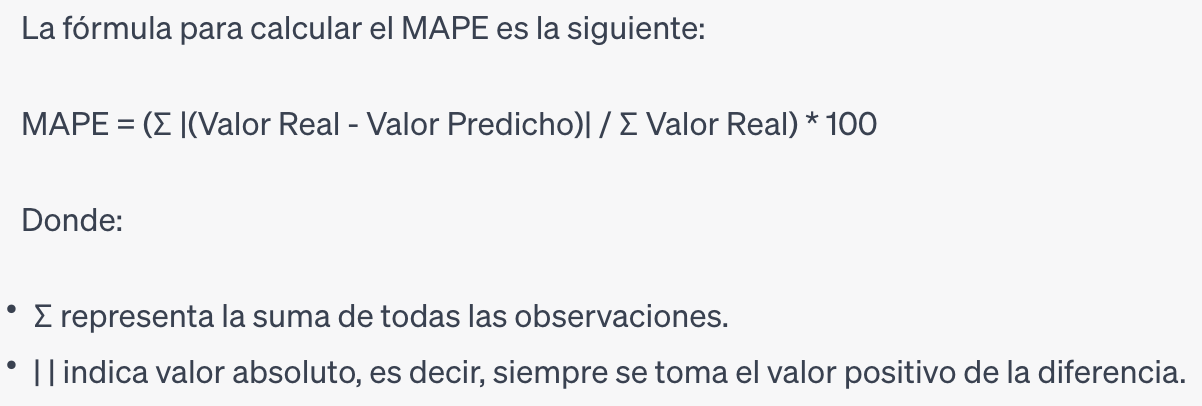

El MAPE proporciona una medida de la precisión relativa del modelo, lo que permite comparar diferentes modelos o enfoques de pronóstico en función de qué tan cerca están sus predicciones de los valores reales en términos porcentuales. Es importante tener en cuenta que el MAPE puede no ser adecuado en todos los casos, especialmente cuando los valores reales son cercanos a cero, ya que puede dar lugar a divisiones por cero o a errores extremadamente grandes. En tales casos, se deben considerar otras métricas de evaluación de modelos.

## **RMSE**

RMSE es la sigla en inglés de "Root Mean Square Error", que en español se traduce como "Error Cuadrático Medio". Es una métrica comúnmente utilizada para evaluar la precisión de un modelo de pronóstico o regresión, comparando las predicciones del modelo con los valores reales.

El RMSE mide la diferencia promedio entre los valores predichos por el modelo y los valores reales, elevando las diferencias al cuadrado para eliminar signos negativos y luego tomando la raíz cuadrada de la media de estos valores. De esta manera, el RMSE penaliza de manera más significativa los errores más grandes, ya que la operación de elevar al cuadrado amplifica dichos errores.


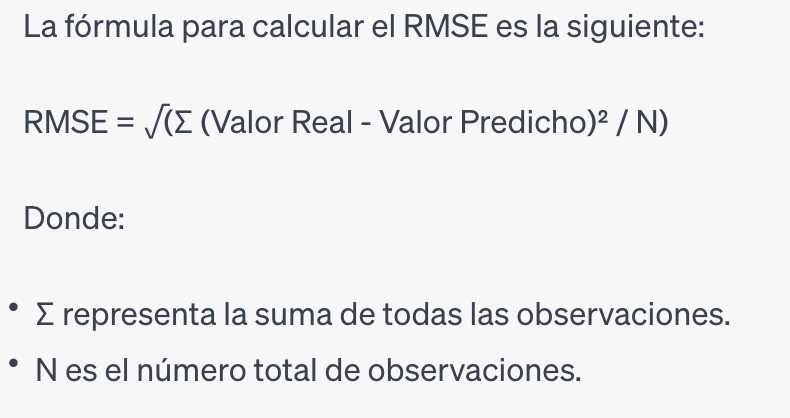

El RMSE se expresa en las mismas unidades que los datos originales, lo que facilita la interpretación y comparación del error con el rango de los valores reales. Cuanto menor sea el valor del RMSE, mejor será la precisión del modelo, ya que indica que las predicciones están más cercanas a los valores reales.

El RMSE se utiliza ampliamente en diferentes campos, como estadísticas, aprendizaje automático, ciencias sociales y economía, entre otros, para evaluar la calidad de los modelos predictivos o para comparar diferentes enfoques de modelado.

In [30]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def rmse (actual, pred):
    actual, pred = np.array (actual), np.array (pred)
    return np.sqrt (np.square (np.subtract (actual, pred)). mean ())

In [31]:
datos_test.head()

y  Predicciones Rf
Date                                   
2023-02-28   96.808948        94.337539
2023-03-31   98.558696        94.012913
2023-04-30  106.348422        94.401140
2023-05-31  116.745682        94.342026
2023-06-30  123.228096        94.342026

In [32]:
Realidad=datos_test["y"]
Predicciones_Rf=datos_test["Predicciones Rf"]

In [33]:
Mape_Test_Rf=MAPE(Realidad,Predicciones_Rf)
print(Mape_Test_Rf)

13.860512860506107


In [34]:
RMSE_Test_RF=rmse(Realidad,Predicciones_Rf)

In [35]:
RMSE_Test_RF

19.2787677236588

## **Ajuste de hiperparámetros (tuning)**

El ForecasterAutoreg entrenado ha utilizado una ventana temporal de 6 lags y un modelo Random Forest con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. Para identificar la mejor combinación de lags e hiperparámetros, la librería Skforecast dispone de la función grid_search_forecaster con la que comparar los resultados obtenidos con cada configuración del modelo.

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )


lags_grid = [6,10,30]
## Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 7]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

In [36]:
#resultados_grid

In [37]:
regressor = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=123)
model_opt = ForecasterAutoreg(
                regressor = regressor,
                lags      = 6
             )

model_opt.fit(y=datos_train['y'])

In [38]:
predicciones_rf1 = model_opt.predict(steps=steps)

In [39]:
datos_test["Predicciones RF1"]=predicciones_rf1.values

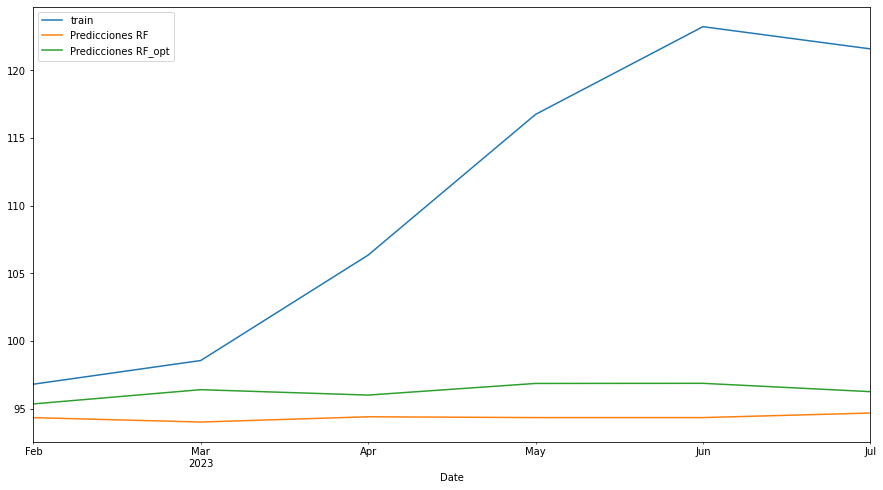

In [40]:
fig, ax = plt.subplots(figsize=(15, 8))
datos_test['y'].plot(ax=ax, label='train')
datos_test['Predicciones Rf'].plot(ax=ax, label='Predicciones RF')
datos_test['Predicciones RF1'].plot(ax=ax, label='Predicciones RF_opt')
ax.legend();

## **XGBoost**

XGBoost, acrónimo de Extreme Gradient Boosting es una implementación muy eficiente del algoritmo de stochastic gradient boosting que se ha convertido en un referente dentro del ámbito de machine learning. Además de su propia API, la librería XGBoost incluye la clase XGBRegressor que sigue la API de scikit learn y, por lo tanto, es compatible con skforecast.

In [41]:
from xgboost import XGBRegressor

In [42]:
model_xgb = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 6
             )

model_xgb.fit(y=datos_train['y'])

In [43]:
predicciones_xgb = model_xgb.predict(steps=steps)

In [44]:
datos_test["Predicciones XGB"]=predicciones_xgb.values

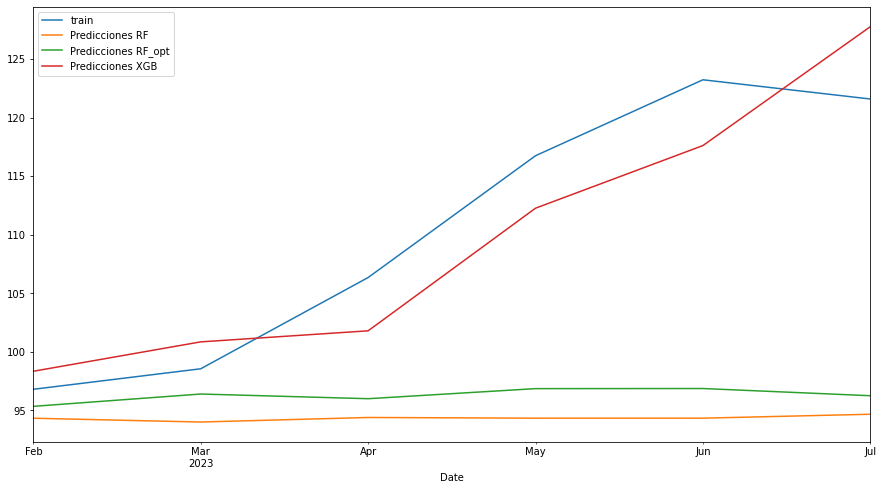

In [45]:
fig, ax = plt.subplots(figsize=(15, 8))
datos_test['y'].plot(ax=ax, label='train')
datos_test['Predicciones Rf'].plot(ax=ax, label='Predicciones RF')
datos_test['Predicciones RF1'].plot(ax=ax, label='Predicciones RF_opt')
datos_test['Predicciones XGB'].plot(ax=ax, label='Predicciones XGB')
ax.legend();

## **Optimización del XGB**

forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
             )

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01,0.05, 0.1]
}

lags_grid = [6, 15, 30]

resultados_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = datos_train['y'],
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = steps,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(datos_train)*0.5), 
        return_best        = True,
        verbose            = False
)

In [46]:
#resultados_grid

In [47]:
model_xgb_opt = ForecasterAutoreg(
                regressor = XGBRegressor(learning_rate=0.10,max_depth=3,n_estimators=500,random_state=123),
                lags = 6
             )

model_xgb_opt.fit(y=datos_train['y'])

In [48]:
predicciones_xgb_opt = model_xgb_opt.predict(steps=steps)
datos_test["Predicciones XGB1"]=predicciones_xgb_opt.values

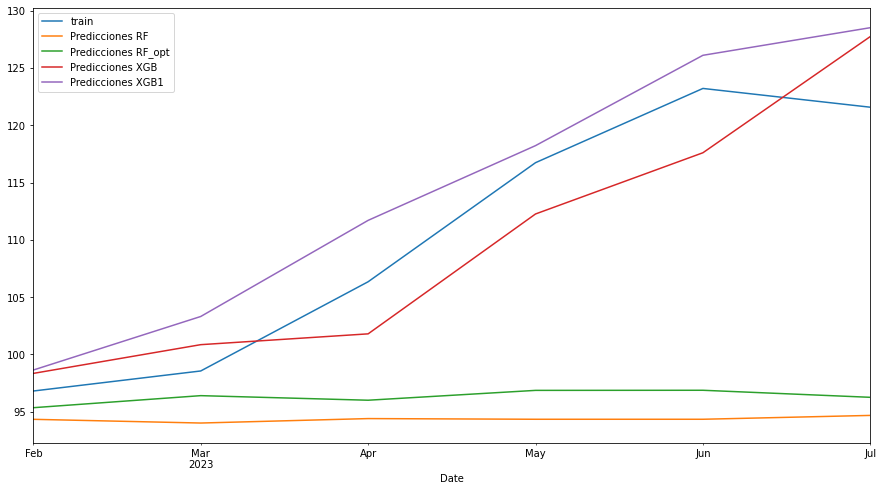

In [49]:
fig, ax = plt.subplots(figsize=(15, 8))
datos_test['y'].plot(ax=ax, label='train')
datos_test['Predicciones Rf'].plot(ax=ax, label='Predicciones RF')
datos_test['Predicciones RF1'].plot(ax=ax, label='Predicciones RF_opt')
datos_test['Predicciones XGB'].plot(ax=ax, label='Predicciones XGB')
datos_test['Predicciones XGB1'].plot(ax=ax, label='Predicciones XGB1')
ax.legend();

## **Phophet**

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El paquete FB Prophet ha sido desarrollado tanto para R como para Python.El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de negocio. Está muy bien documentado en su web, por lo que es fácil aprender a usarlo y de ajustarlo

* https://facebook.github.io/prophet/docs/quick_start.html#python-api

* Modelado aditivo: FB Prophet utiliza un modelo aditivo, lo que significa que descompone las series temporales en componentes separados, como tendencia, estacionalidad y efectos de días festivos. Esto permite capturar patrones complejos en los datos y mejorar la precisión de las predicciones.

* Robustez ante datos faltantes y ruido: FB Prophet puede manejar datos faltantes y cierto grado de ruido en las series temporales, lo que lo hace más confiable en situaciones donde los datos pueden ser incompletos o ligeramente imprecisos.

In [50]:
# fbprophet
#!pip install fbprophet

In [51]:
from prophet import Prophet

In [52]:
df=datos_train[["y"]]

In [53]:
df["ds"]=df.index

In [54]:
df=df[["ds","y"]]

In [55]:
df.head()

ds          y
Date                            
2017-01-31 2017-01-31  40.395238
2017-02-28 2017-02-28  40.845829
2017-03-31 2017-03-31  41.705565
2017-04-30 2017-04-30  42.202843
2017-05-31 2017-05-31  46.964205

In [56]:
df=df.reset_index(drop=True)

In [57]:
df.head()

ds          y
0 2017-01-31  40.395238
1 2017-02-28  40.845829
2 2017-03-31  41.705565
3 2017-04-30  42.202843
4 2017-05-31  46.964205

In [58]:
m = Prophet()
m.fit(df)

prophet    INFO  Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: /var/folders/vt/2t0v0kt92gj1_bvmhn234x6ng8b83c/T/tmpu8fn9rf4/v2wwgi8p.json
cmdstanpy  DEBUG input tempfile: /var/folders/vt/2t0v0kt92gj1_bvmhn234x6ng8b83c/T/tmpu8fn9rf4/48f2pvhv.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['/Users/osgaspar/opt/anaconda3/envs/Personal/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31892', 'data', 'file=/var/folders/vt/2t0v0kt92gj1_bvmhn234x6ng8b83c/T/tmpu8fn9rf4/v2wwgi8p.json', 'init=/var/folders/vt/2t0v0kt92gj1_bvmhn234x6ng8b83c/T/tmpu8fn9rf4/48f2pvhv.json', 'output', 'file=/var/folders/vt/2t0v0kt92gj1_bvmhn234x6ng8b83c/T/tmpu8fn9rf4/prophet_modelwm8fyzj8/prophet_model-20230726180205.csv', 'method=optimize', 'alg

In [59]:
future=m.make_future_dataframe(periods=steps)

In [60]:
forecast = m.predict(future)

In [61]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
74 2023-02-02  158.927229  137.410308  178.200249
75 2023-02-03  178.408392  159.331499  199.605695
76 2023-02-04  197.969832  177.629307  217.870640
77 2023-02-05  217.162561  196.288205  236.815340
78 2023-02-06  235.542337  217.554223  255.878228

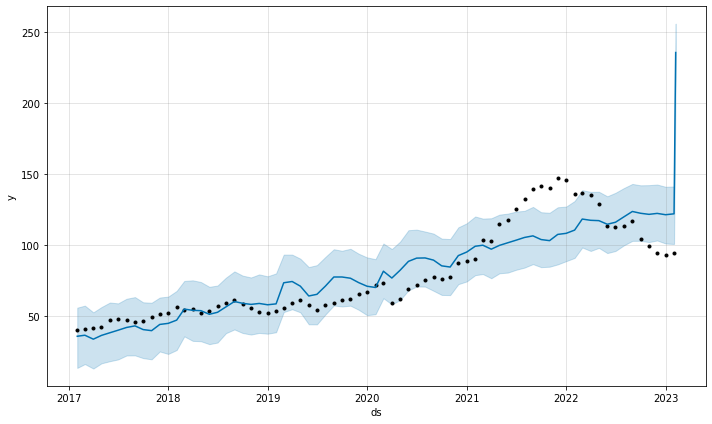

In [62]:
fig1 = m.plot(forecast)

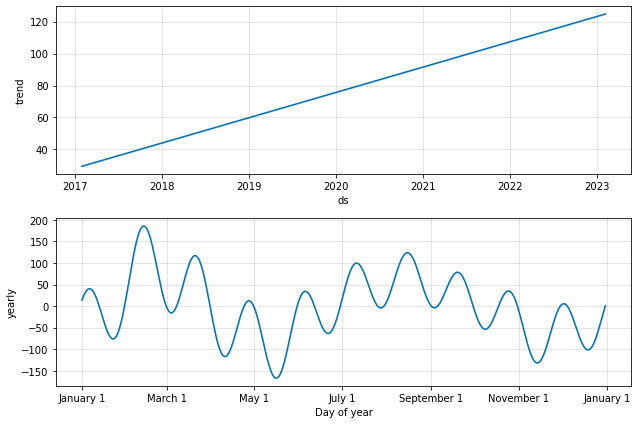

In [63]:
fig2 = m.plot_components(forecast)

In [64]:
Predicciones_FB=forecast[["ds","yhat"]][len(datos_train):]

In [65]:
Predicciones_FB.shape

(6, 2)

In [66]:
datos_test["Predicciones Prophet"]=Predicciones_FB.yhat.values

In [67]:
datos_test.head()

y  Predicciones Rf  Predicciones RF1  Predicciones XGB  \
Date                                                                          
2023-02-28   96.808948        94.337539         95.351667         98.347160   
2023-03-31   98.558696        94.012913         96.403658        100.855545   
2023-04-30  106.348422        94.401140         96.004582        101.799698   
2023-05-31  116.745682        94.342026         96.864314        112.267166   
2023-06-30  123.228096        94.342026         96.873606        117.612953   

            Predicciones XGB1  Predicciones Prophet  
Date                                                 
2023-02-28          98.640404            139.967778  
2023-03-31         103.316078            158.927229  
2023-04-30         111.708801            178.408392  
2023-05-31         118.235130            197.969832  
2023-06-30         126.121872            217.162561

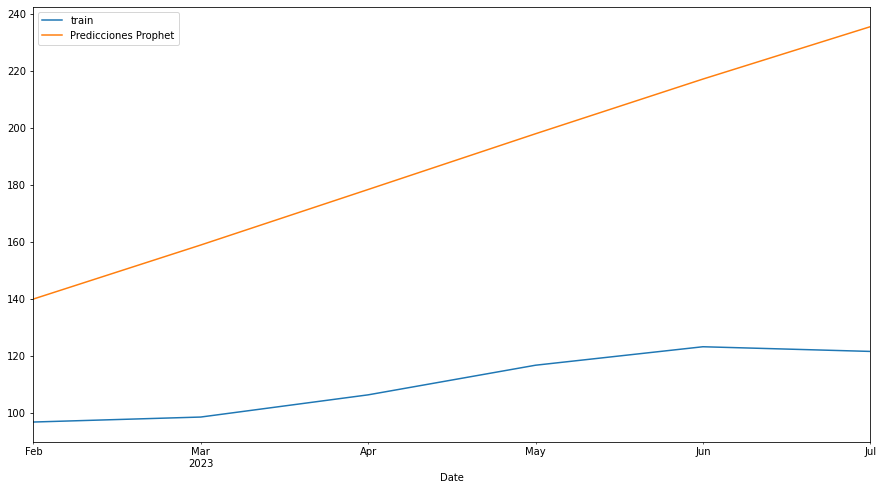

In [68]:
fig, ax = plt.subplots(figsize=(15, 8))
datos_test['y'].plot(ax=ax, label='train')
#datos_test['Predicciones Rf'].plot(ax=ax, label='Predicciones RF')
#datos_test['Predicciones RF1'].plot(ax=ax, label='Predicciones RF_opt')
#datos_test['Predicciones XGB'].plot(ax=ax, label='Predicciones XGB')
#datos_test['Predicciones XGB1'].plot(ax=ax, label='Predicciones XGB1')
datos_test['Predicciones Prophet'].plot(ax=ax, label='Predicciones Prophet')
ax.legend();

## **SARIMAX**

In [69]:
datos_train

y
Date                  
2017-01-31   40.395238
2017-02-28   40.845829
2017-03-31   41.705565
2017-04-30   42.202843
2017-05-31   46.964205
...                ...
2022-09-30  104.108571
2022-10-31   99.462858
2022-11-30   94.113334
2022-12-31   92.733809
2023-01-31   94.016001

[73 rows x 1 columns]

In [70]:
import statsmodels.api as sm 
from pylab import rcParams

In [71]:
def Optimizacion_SARIMA(y):
    import itertools
    p=d=q=range(0,2)
    pdq=list(itertools.product(p,d,q))

    seasonal_pdq=[(x[0],x[1],x[2],12) for x in list(itertools.product(p,q,d))]

    p1=[]
    p2=[]
    p3=[]
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod=sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results=mod.fit()
                p1.append(param)
                p2.append(param_seasonal)
                p3.append(results.aic)
            except:
                continue
    df1 = pd.DataFrame({'param' : p1, 'param_seasonal' :p2,"results.aic":p3})
    td=df1[df1["results.aic"]==min(p3)]
    return td


In [72]:
td=Optimizacion_SARIMA(datos_train)

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79370D+00    |proj g|=  1.24383D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   3.642D-09   5.794D+00
  F =   5.7936748570546079     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.3

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.95064D+00    |proj g|=  1.89085D-01

At iterate   25    f=  3.94179D+00    |proj g|=  3.64523D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     39      1     0     0   1.427D-06   3.942D+00
  F =   3.9417886392831294     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93709D+00    |proj g|=  4.36178D-01

At iterate    5    f=  3.59906D+00    |proj g|=  5.01441D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64511D+00    |proj g|=  6.74824D-01

At iterate    5    f=  4.52063D+00    |proj g|=  1.32254D-02

At iterate   10    f=  4.11559D+00    |proj g|=  3.61448D-01

At iterate   15    f=  3.57369D+00    |proj g|=  4.31679D-01

At iterate   20    f=  3.51560D+00    |proj g|=  8.61235D-02

At iterate   25    f=  3.51163D+00    |proj g|=  7.97051D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     40      1     0     0   

 This problem is unconstrained.



At iterate   15    f=  4.03754D+00    |proj g|=  5.73123D-01

At iterate   20    f=  3.57326D+00    |proj g|=  2.31902D-01

At iterate   25    f=  3.50243D+00    |proj g|=  2.39210D-01

At iterate   30    f=  3.46362D+00    |proj g|=  9.19304D-02

At iterate   35    f=  3.44100D+00    |proj g|=  2.97407D-02

At iterate   40    f=  3.42747D+00    |proj g|=  7.01888D-02

At iterate   45    f=  3.42095D+00    |proj g|=  2.34583D-02

At iterate   50    f=  3.41630D+00    |proj g|=  5.35602D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     74      1     0     0   5.356D-02   3.416D+00
  F =   3.41629733759

/Users/osgaspar/opt/anaconda3/envs/Personal/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28084D+00    |proj g|=  3.51946D-01

At iterate    5    f=  3.00562D+00    |proj g|=  2.91085D-02

At iterate   10    f=  3.00530D+00    |proj g|=  2.20424D-01

At iterate   15    f=  2.91039D+00    |proj g|=  1.62954D-01

At iterate   20    f=  2.90137D+00    |proj g|=  4.03080D-02
  ys=-6.666E-03  -gs= 5.173E-03 BFGS update SKIPPED

At iterate   25    f=  2.89113D+00    |proj g|=  4.09335D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

 This problem is unconstrained.



At iterate    5    f=  2.89191D+00    |proj g|=  1.23223D-01

At iterate   10    f=  2.87991D+00    |proj g|=  1.65405D-02

At iterate   15    f=  2.79251D+00    |proj g|=  4.72897D-02

At iterate   20    f=  2.78891D+00    |proj g|=  1.21436D-02

At iterate   25    f=  2.78541D+00    |proj g|=  2.03394D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     62      1     0     0   5.499D-05   2.785D+00
  F =   2.7854145771104641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74155D+00    |proj g|=  2.96300D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      5      1     0     0   5.815D-06   2.732D+00
  F =   2.7319113095559624     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60206D+00    |proj g|=  3.82503D-02

At iterate    5    f=  2.60079D+00    |proj g|=  4.95248D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   4.952D-07   2.601D+00
  F =   2.6007875489871437     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10196D+00    |proj g|=  2.33043D-01

At iterate    5    f=  2.06303D+00    |proj g|=  1.68550D-02

At iterate   10    f=  2.05619D+00    |proj g|=  9.83578D-03

At iterate   15    f=  2.05560D+00    |proj g|=  3.03193D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     19      1     0     0   5.503D-06   2.056D+00
  F =   2.0555998789071563     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine 

/Users/osgaspar/opt/anaconda3/envs/Personal/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 This problem is unconstrained.
/Users/osgaspar/opt/anaconda3/envs/Personal/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73661D+00    |proj g|=  1.29465D+00

At iterate    5    f=  2.61694D+00    |proj g|=  1.13705D-01

At iterate   10    f=  2.54109D+00    |proj g|=  6.44682D-01

At iterate   15    f=  2.53820D+00    |proj g|=  7.06404D-02

At iterate   20    f=  2.53538D+00    |proj g|=  4.85964D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     22      1     0     0   4.860D-05   2.535D+00
  F =   2.5353795760008997     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.23269D+00    |proj g|=  3.38194D-02

At iterate   20    f=  2.21734D+00    |proj g|=  4.01396D-02

At iterate   25    f=  2.20850D+00    |proj g|=  4.12647D-02

At iterate   30    f=  2.20453D+00    |proj g|=  3.79441D-02

At iterate   35    f=  2.20162D+00    |proj g|=  1.57379D-02

At iterate   40    f=  2.19977D+00    |proj g|=  9.73520D-02

At iterate   45    f=  2.19845D+00    |proj g|=  5.02501D-02

At iterate   50    f=  2.19728D+00    |proj g|=  1.01917D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     75      1     0     0   1.019D-01   2.197D+00
  F =   2.19727688753

/Users/osgaspar/opt/anaconda3/envs/Personal/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.56758D+00    |proj g|=  1.60722D-01

At iterate   10    f=  2.55709D+00    |proj g|=  1.66964D-01

At iterate   15    f=  2.48899D+00    |proj g|=  3.32603D-01

At iterate   20    f=  2.47781D+00    |proj g|=  1.63822D-01

At iterate   25    f=  2.47466D+00    |proj g|=  4.69382D-02

At iterate   30    f=  2.47357D+00    |proj g|=  7.06730D-02

At iterate   35    f=  2.47337D+00    |proj g|=  2.36023D-02

At iterate   40    f=  2.47332D+00    |proj g|=  1.70120D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     56      1     0     0   2.572D-04   2.473D+00
  F =   2.47332135776

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.07389D+00    |proj g|=  1.62420D-01

At iterate   20    f=  2.07204D+00    |proj g|=  4.83844D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   4.921D-06   2.072D+00
  F =   2.0720419500872205     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84788D+00    |proj g|=  6.59838D-01

At iterate    5    f=  2.57175D+00    |proj g|=  2.56384D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.15858D+00    |proj g|=  1.31463D-02

At iterate   10    f=  2.15838D+00    |proj g|=  1.52094D-02

At iterate   15    f=  2.15820D+00    |proj g|=  8.61540D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   1.324D-05   2.158D+00
  F =   2.1581974564422981     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73258D+00    |proj g|=  1.44487D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.46702D+00    |proj g|=  6.61971D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   6.351D-06   2.467D+00
  F =   2.4670153762556053     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13695D+00    |proj g|=  1.32111D-01

At iterate    5    f=  2.11777D+00    |proj g|=  2.17122D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.41917D+00    |proj g|=  1.03935D-03

At iterate   15    f=  2.41916D+00    |proj g|=  2.11771D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     20      1     0     0   1.254D-06   2.419D+00
  F =   2.4191559199100792     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59176D+00    |proj g|=  3.70214D-03

At iterate    5    f=  2.59153D+00    |proj g|=  2.72843D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.42796D+00    |proj g|=  1.02178D-01

At iterate   10    f=  2.41917D+00    |proj g|=  3.68561D-03

At iterate   15    f=  2.41916D+00    |proj g|=  5.25871D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   3.728D-06   2.419D+00
  F =   2.4191554642036652     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13712D+00    |proj g|=  1.30600D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.02407D+00    |proj g|=  3.82937D-01

At iterate   15    f=  2.01868D+00    |proj g|=  4.85934D-03

At iterate   20    f=  2.01794D+00    |proj g|=  7.24167D-02

At iterate   25    f=  2.01775D+00    |proj g|=  1.90431D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     41      1     0     0   1.375D-06   2.018D+00
  F =   2.0177534896621281     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [73]:
td

param param_seasonal  results.aic
59  (1, 1, 1)  (0, 1, 1, 12)    302.59203

In [74]:
mododelo_Accion=sm.tsa.statespace.SARIMAX(datos_train,
                              order=(0,1 ,1),
                              seasonal_order=(0,0,1,12),
                              enforce_stationarity=False,
                              enforce_invertibility=False)

In [75]:
resultados=mododelo_Accion.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44930D+00    |proj g|=  1.00188D-01

At iterate    5    f=  2.43781D+00    |proj g|=  4.16009D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   2.770D-06   2.438D+00
  F =   2.4378107686770849     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [76]:
print(resultados.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2747      0.146      1.882      0.060      -0.011       0.561
ma.S.L12       0.1307      0.179      0.730      0.466      -0.220       0.482
sigma2        26.9856      3.908      6.906      0.000      19.327      34.644


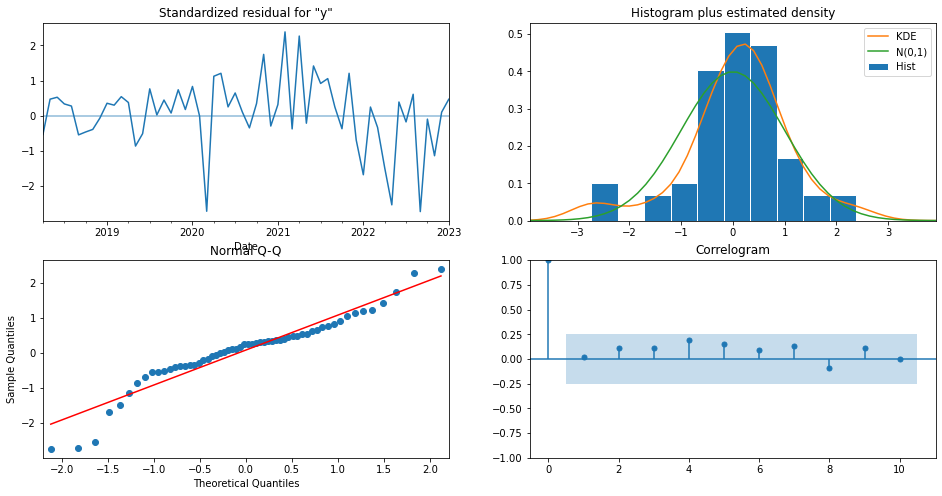

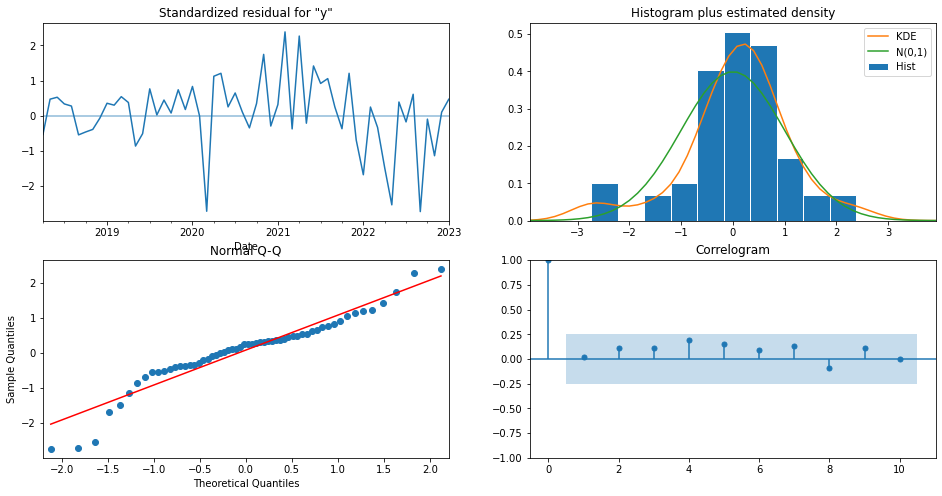

In [77]:
resultados.plot_diagnostics(figsize=(16,8))

**Predicciones**

In [78]:
Pred_uc=resultados.get_forecast(steps=steps)

In [79]:
Pred_uc.predicted_mean

2023-02-28    94.531199
2023-03-31    94.347049
2023-04-30    93.272923
2023-05-31    91.265145
2023-06-30    91.052790
2023-07-31    91.002383
Freq: M, Name: predicted_mean, dtype: float64

In [80]:
datos_test["Prediccion SARIMA"]=Pred_uc.predicted_mean.values

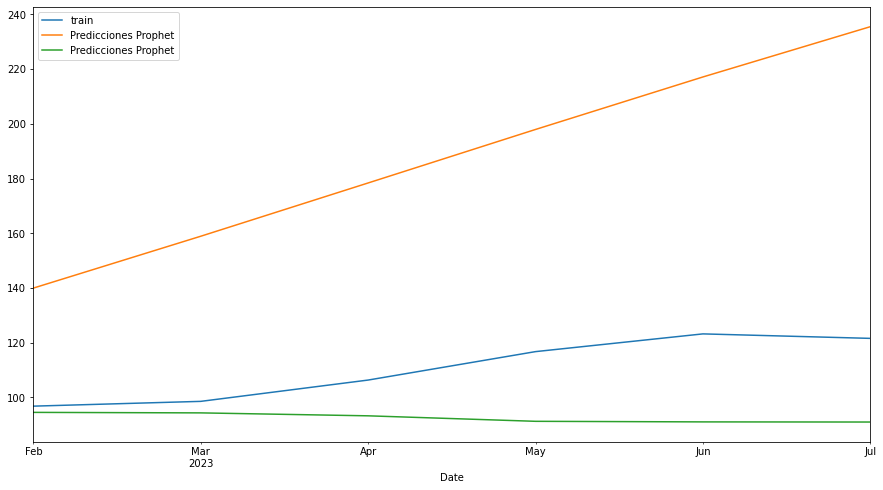

In [81]:
fig, ax = plt.subplots(figsize=(15, 8))
datos_test['y'].plot(ax=ax, label='train')
#datos_test['Predicciones Rf'].plot(ax=ax, label='Predicciones RF')
#datos_test['Predicciones RF1'].plot(ax=ax, label='Predicciones RF_opt')
#datos_test['Predicciones XGB'].plot(ax=ax, label='Predicciones XGB')
#datos_test['Predicciones XGB1'].plot(ax=ax, label='Predicciones XGB1')
datos_test['Predicciones Prophet'].plot(ax=ax, label='Predicciones Prophet')
datos_test["Prediccion SARIMA"].plot(ax=ax, label='Predicciones Prophet')
ax.legend();